In [1]:
import os
os.chdir('..')

# Set up environment

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pickle
import pandas_market_calendars as mcal
from tqdm import tqdm
import torch
torch.set_float32_matmul_precision('high')
from gymnasium import spaces
from mmd.env import GenLSTM, MMDSimulator, load_generator
from mmd.train import start_writer, get_params_from_events, get_params_dicts, get_robustq_params_dicts, train_robustdqn, training_info
from mmd.evaluation import simulate_agent_spx, generate_graph
from agent.q import QFunc
from agent.DQN import PORDQN

In [3]:
total_length = 560
burn_in = 500
state_len = 60
cal_start_date = '1995-01-01'
cal_end_date = '2023-12-31'
trading_calendar = 'NYSE'
calendar = mcal.get_calendar(trading_calendar)
schedule = calendar.schedule(start_date=cal_start_date, end_date=cal_end_date)

int_rate = 0.024
trans_cost = 0.0005 # standard cost = 0.0005
eval_batch_size = 1000
eval_seed = 12345

In [4]:
with open('./dataset/lstm/ma_params.pkl', 'rb') as f:
    ma_model_params = pickle.load(f)

In [5]:
events_path = './dataset/lstm/'
params = get_params_from_events(events_path)
for key, value in params.items():
    for key, value in value.items():
        if key in globals(): continue # skip if already in globals
        globals()[key] = value
data_params, model_params, train_params = get_params_dicts(vars().copy())

In [6]:
seed = 0 # results in the paper used 0, 1, 2, 3, 4

generator = GenLSTM(4, 1, 60)
generator = load_generator(generator, events_path)

# Robust DQN

In [7]:
torch.manual_seed(seed)
batch_size = 8
device =  'cpu'
action_space = spaces.Discrete(9)
action_values = torch.linspace(-1., 1., 9, device=device)
num_actions = len(action_values)
nu_dist = 't'
nu_scale = 0.03
nu_df = 2
other_state_vars = ['log_wealth', 'positions', 'dt']
obs_dim = state_len + len(other_state_vars)

## Training from scratch

In [8]:
# RUN IF TRAINING FROM SCRATCH
discount = 0.99
eps_greedy = 0.1 # epsilon greedy parameter
buffer_max_length = int(1e5)
clone_steps = 50
train_steps = 1
agent_batch_size = 128
n_batches = 1
n_epochs = 1
robustq_lr = 1e-4
architecture = [64, 64]
pre_train_Q = False
n_episodes = 2

robustq = QFunc(state_len+len(other_state_vars), architecture, action_values.shape[0]).to(device)

delta = 1e-4 # regularisation parameter for Sinkhorn distance
epsilon = 0.003 # Sinkhorn distance
norm_ord = 1
lamda_init = 0. # initial lambda
lamda_max_iter = 100
lamda_step_size = 10 # step size for learning rate scheduler
lamda_gamma = 10 # gamma for learning rate scheduler
lamda_lr = 0.02 # learning rate for lambda
n_outer = 1 # not used in this algorithm but used in logging by writer
n_inner = 1000 # number of samples from nu to calc inner expectations

# [0.1,0.18,0.23,0.27,1,2,100,10000000,10000000,10000000] 

simulator_params, model_params = get_robustq_params_dicts(vars().copy())
writer = start_writer(simulator_params, model_params, model_name='PORDQN')

In [ ]:
env = MMDSimulator(generator, ma_model_params, trading_calendar, cal_start_date, cal_end_date, state_len, burn_in,int_rate, trans_cost, batch_size, action_space, action_values, device)

robustdqn_agent = PORDQN(obs_dim, num_actions, discount, nu_scale, nu_df, action_values, epsilon, delta, n_inner, lamda_init,lamda_lr, lamda_max_iter, lamda_step_size, lamda_gamma, norm_ord, robustq, eps_greedy, buffer_max_length, clone_steps, train_steps, agent_batch_size, n_batches, n_epochs, robustq_lr, device=device, seed=seed, writer=writer)

## Evaluation

In [10]:
import random

path = "original/original_5eps"
checkpoint_path = f"runs/{path}/checkpoint.pt"

checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=torch.device('cpu'))

robustdqn_agent.steps = checkpoint['agent_steps']
robustdqn_agent.q_updates = checkpoint['agent_q_updates']
robustdqn_agent.q.load_state_dict(checkpoint['agent_state_dict'])
robustdqn_agent.target_q.load_state_dict(checkpoint['agent_target_q'])
robustdqn_agent.optimizer.load_state_dict(checkpoint['agent_optimizer'])
robustdqn_agent.buffer = checkpoint['agent_buffer']
robustdqn_agent.rng.bit_generator.state = checkpoint['numpy_rng_state']
robustdqn_agent.epsilon = checkpoint['agent_eps_greedy']
random.setstate(checkpoint['random_state'])
torch.set_rng_state(checkpoint['torch_rng_state'])


In [ ]:
robustdqn_agent.steps

13478

In [11]:
robustdqn_agent.training_mode = False
torch.manual_seed(eval_seed)
dqn_eval_env = MMDSimulator(generator, ma_model_params, trading_calendar, cal_start_date, cal_end_date, state_len, burn_in, batch_size=eval_batch_size, logging=True, action_space=action_space, action_values=action_values, int_rate=int_rate, trans_cost=trans_cost)
obs, reset_info = dqn_eval_env.reset()
action = robustdqn_agent.get_action(obs)
done = torch.tensor([False] * batch_size)
while not done.any():
    obs, reward, done, truncated, info = dqn_eval_env.step(action)
    if done.any():
        break
    else:
        action = robustdqn_agent.get_action(obs)
dqn_eval_env.print_metrics()

Mean final log wealth eval vs env: 3.285 vs 2.723
Mean final wealth eval vs env: 28.433 vs 19.706
Mean return vol eval vs env: 0.065 vs 0.140
Mean sharpes eval vs env: 1.911 vs 0.729
Mean downside dev eval vs env: 0.037 vs 0.084
Mean sortino eval vs env: 3.332 vs 1.223


In [12]:
print("Performance on S&P 500:")
simulate_agent_spx(robustdqn_agent.q, action_values, int_rate=int_rate, trans_cost=trans_cost)

Performance on S&P 500:


{'final_wealth': 0.9300605797127803,
 'max_drawdown': -0.5511131369291874,
 'sharpe': -0.019067498638176177,
 'volatility': 0.13239132298298095,
 'down_deviation': 0.0942699749697231,
 'sortino': -0.02677810587618263,
 'spx_final_wealth': 9.524411783739737,
 'spx_max_drawdown': -0.5677538774277282,
 'spx_sharpe': 0.40986550593061494,
 'spx_volatility': 0.19130311470223205,
 'spx_down_deviation': 0.13779502078420072,
 'spx_sortino': 0.5690230855026872}

position
 1.00    3583
-0.25    1262
 0.50    1068
 0.00     689
 0.25     222
 0.75     195
-0.50     188
-0.75      28
-1.00       4
Name: count, dtype: int64


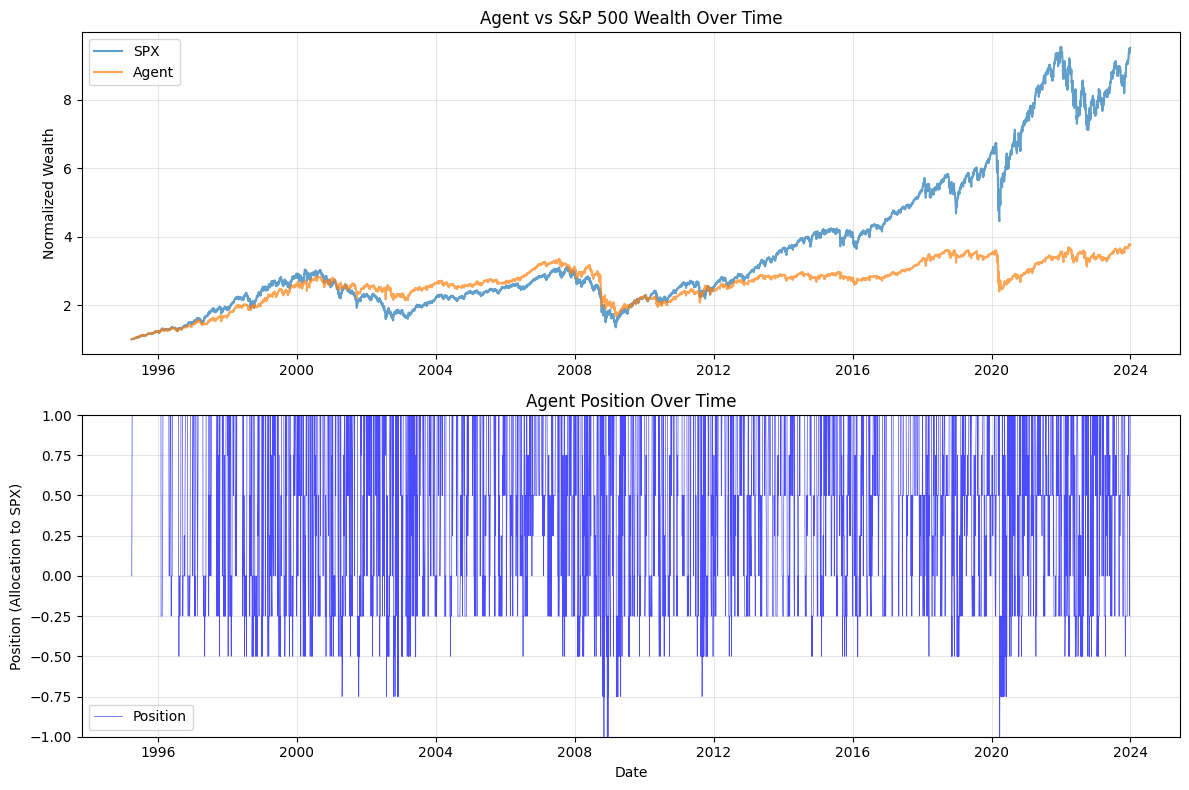

In [31]:
generate_graph(robustdqn_agent.q, action_values, int_rate=int_rate, trans_cost=trans_cost)

In [ ]:
path = "original/original_5eps"
# path = "txn_0.05/eps_3/0"
training_path = f"runs/{path}/"

all_params = training_info(training_path)

In [ ]:
iters = all_params['Lambda/iterations']
iters['Value'].plot()
# iters['Value'].hist(bins=100)
iters['Value'].value_counts().head(10)

<Axes: >

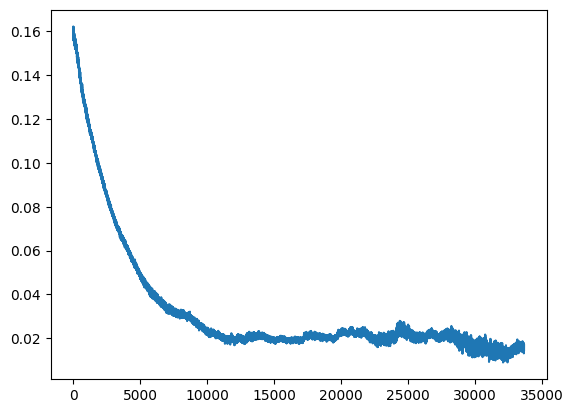

In [ ]:
iters = all_params['HQ/mean_HQ_values']
iters['Value'].plot()

# print(lamda_init)

In [27]:
all_params['mean_cum_rewards']


,Reward
Episode,
1,1.318960
2,2.502412
3,2.767347
4,2.713185
5,2.856450


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lr(lamda_lr, lambda_gamma, lamda_step_size):
    total_steps = 101

    # Calculate learning rate at each step
    steps = np.arange(total_steps)
    learning_rates = []

    for step in steps:
        # Learning rate is multiplied by gamma every step_size steps
        current_lr = lamda_lr * (lamda_gamma ** (step // lamda_step_size))
        learning_rates.append(current_lr)

    learning_rates = np.array(learning_rates)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(steps, learning_rates, linewidth=2, color='#2E86AB')
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Learning Rate (log scale)', fontsize=12)
    plt.title(f'Original Lambda Scheduler', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    n = 5  # every nth tick to annotate
    xticks = plt.xticks()[0]  # get tick positions
    for i, x in enumerate(xticks):
        if i % (n / (xticks[1] - xticks[0])) == 0 and x in steps:
            y = learning_rates[int(x)]
            plt.text(x, y, f'{y:.3f}',
                    ha='center', va='bottom',
                    fontsize=8, color='black')

    plt.semilogy()
    plt.show()

    # Print summary statistics
    print("Learning Rate Evolution Summary")
    print("=" * 50)
    print(f"Initial LR: {lamda_lr}")
    print(f"Gamma: {lamda_gamma}")
    print(f"Step Size: {lamda_step_size}")
    print(f"Total Steps: {total_steps}")
    print(f"\nLR at key steps:")
    print(f"  Step 5: {learning_rates[5]:.6f}")
    print(f"  Step 10: {learning_rates[10]:.6f}")
    print(f"  Step 15: {learning_rates[15]:.6f}")
    print(f"  Step 25: {learning_rates[25]:.6f}")
    print(f"  Step 40: {learning_rates[40]:.6f}")
    print(f"  Step 50: {learning_rates[50]:.6f}")
    print(f"  Step 60: {learning_rates[60]:.6f}")
    print(f"  Step 75: {learning_rates[75]:.6f}")
    print(f"  Step 99: {learning_rates[99]:.6f}")
    print(f"\nFinal LR / Initial LR ratio: {learning_rates[-1]/learning_rates[0]:.2f}x")
    print(f"Number of LR updates: {total_steps // lamda_step_size}")


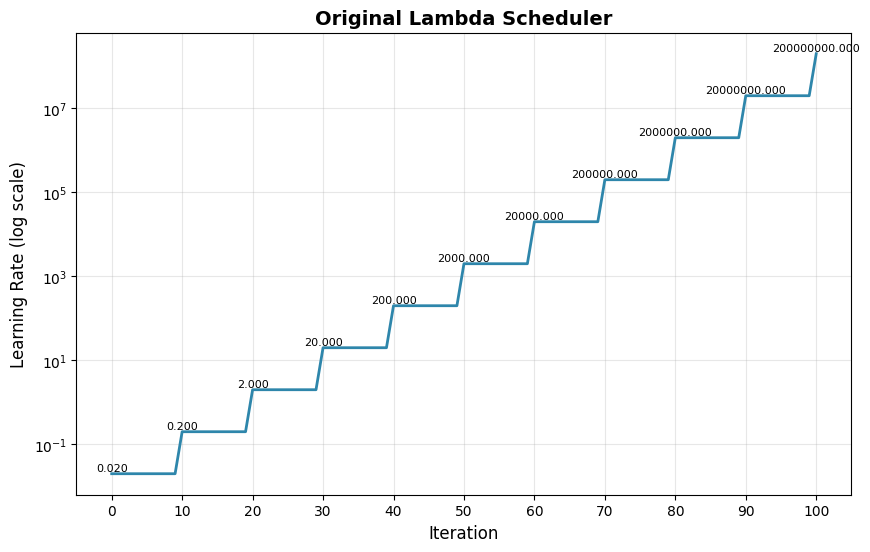

Learning Rate Evolution Summary
Initial LR: 0.02
Gamma: 10
Step Size: 10
Total Steps: 101

LR at key steps:
  Step 5: 0.020000
  Step 10: 0.200000
  Step 15: 0.200000
  Step 25: 2.000000
  Step 40: 200.000000
  Step 50: 2000.000000
  Step 60: 20000.000000
  Step 75: 200000.000000
  Step 99: 20000000.000000

Final LR / Initial LR ratio: 10000000000.00x
Number of LR updates: 10


In [20]:
# lamda_lr = 0.02
# lamda_gamma = 10
# lamda_step_size = 10

lamda_lr = 0.02
lamda_gamma = 10
lamda_step_size = 10
plot_lr(lamda_lr, lamda_gamma, lamda_step_size)

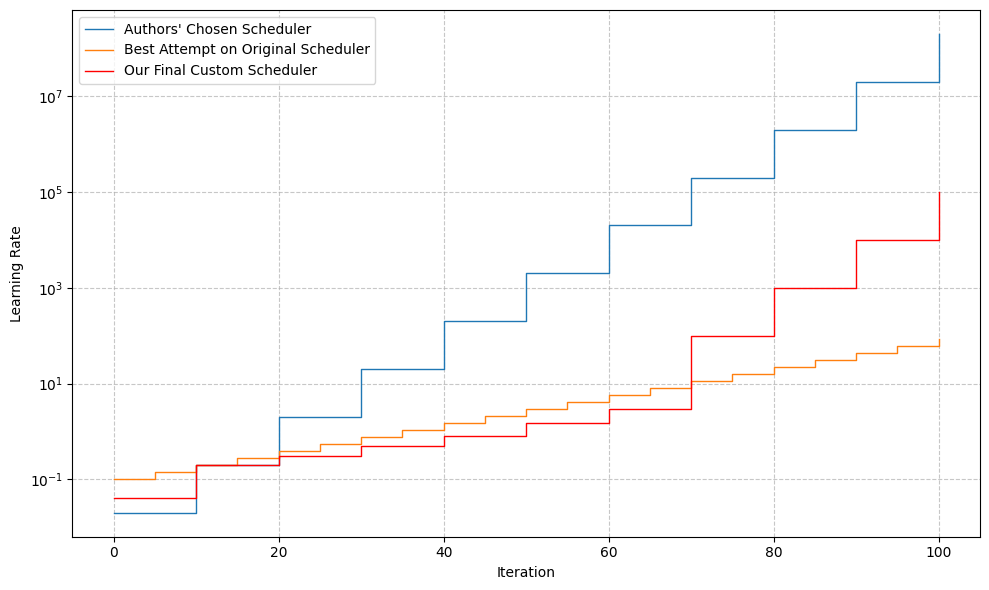

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Data
y1 = [0.04,0.2,0.3,0.5,0.8,1.5,3,100,1000,10000,100000]
y2 = [0.02, 0.2, 2, 20, 200, 2e3, 2e4, 2e5, 2e6, 2e7, 2e8]
y3 = [0.1 * (1.4**i) for i in range(21)]

# X-axis: each step (e.g., 0, 10, 20, ..., 100)
x = np.arange(0, len(y2)*10, 10)
x2 = np.arange(0, len(y3)*5, 5)

plt.figure(figsize=(10,6))
plt.plot(x, y2, label='Authors\' Chosen Scheduler', linewidth=1, drawstyle='steps-post')
plt.plot(x2, y3, label='Best Attempt on Original Scheduler', linewidth=1, drawstyle='steps-post')
plt.plot(x, y1, label='Our Final Custom Scheduler', linewidth=1, drawstyle='steps-post', color="red")

 # log scale makes exponential growth clearer
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
# plt.title('Comparison of Lambda Scheduler Growth Rates (Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
